# Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import xgboost
from tqdm.notebook import tqdm

from numba import njit, prange
from multiprocessing import Pool, cpu_count


# Funções

A seguir temos as funções que utilizaremos na simulação.

Temos o cálculo de $ a = \frac{K_c \cdot (b_1 + b_2)}{n_1 \cdot L \cdot b_1 \cdot b_2} $,

o cálculo de $ b = \frac{K_c}{n_1 \cdot E} $,

o cálculo de $c = \frac{1}{n_1} \cdot \left(K_c - F_d \cdot (p_m + i_r - e_r - r)\right)$

e por fim, o cálculo da probabilidade $$
p(x, t, a, b, c, x_0, F_d, n_1) = \frac{1}{\sqrt{2 \pi t \left(\frac{F_d}{n_1}\right)^2}}
\cdot \exp\left(
-\frac{\left[t (a x^2 + b x + c) + x - x_0\right]^2}{2 t \left(\frac{F_d}{n_1}\right)^2}
+ t (2 a x + b)
\right)
$$


In [2]:

# Funções previamente definidas
@njit
def calc_a(Kc, b1, b2, L, n1):
    return Kc * (b1 + b2) / (n1 * L * b1 * b2)

@njit
def calc_b(Kc, E, n1):
    return Kc / (n1 * E)

@njit
def calc_c(Kc, Fd, pm, ir, er, r, n1):
    return (1.0 / n1) * (Kc - Fd * (pm + ir - er - r))

@njit
def p(x, t, a, b, c, x0, Fd, n1):

    fdn1 = Fd/n1
    term0 = 1.0 / np.sqrt(2.0 * np.pi * t * fdn1*fdn1)
    term1 = (t * (a * x*x + b * x + c) + x - x0)
    den   = 2.0*t*fdn1*fdn1
    term2 = t * (2.0 * a * x + b)

    return term0 * np.exp(-(term1*term1)/den + term2)


### Funções auxiliares

Otimizadas para calcular com base em t de forma paralela



In [3]:
from numba import njit, prange

@njit(parallel=True)
def integral_p(p, t, a, b, c, x0, fdi, n1, dx=0.25, x_start=4.38, x_end=15):
    """
    Calcula a integral aproximada de p(x, t) usando a soma de Riemann.

    Parâmetros:
        p (function): Função que será integrada, p(x, t, a, b, c, x0, fdi, n1).
        t (float): Parâmetro t para a função p.
        a: valor de a.
        b: valor de b.
        c: valor de c.
        x0 (float): Parâmetro x0 para a função p.
        fdi (float): Parâmetro fdi para a função p.
        n1 (float): Parâmetro n1 para a função p.
        dx (float, opcional): Incremento no intervalo de integração. Default é 0.25.
        x_start (float, opcional): Início do intervalo de integração. Default é 4.38.
        x_end (float, opcional): Fim do intervalo de integração. Default é 15.

    Retorna:
        float: Valor da integral aproximada.
    """
    npassos = int((x_end - x_start) / dx) + 1
    s = 0.0
    for i in prange(npassos):  # loop paralelizado
        x = x_end - i * dx
        s += p(x, t, a, b, c, x0, fdi, n1)
    return s*dx




from numba import njit, prange

@njit(parallel=True)
def normalizacao(p, t, a, b, c, x0, fdi, n1, x_start=1e-4, x_end=15, dx=0.25):
    """
    Calcula a normalização de p(x, t) usando uma soma discreta.

    Parâmetros:
        p (function): Função que será integrada, p(x, t, a, b, c, x0, fdi, n1).
        t (float): Parâmetro t para a função p.
        a: valor de a.
        b: valor de b.
        c: valor de c.
        x0 (float): Parâmetro x0 para a função p.
        fdi (float): Parâmetro fdi para a função p.
        n1 (float): Parâmetro n1 para a função p.
        x_start (float, opcional): Início do intervalo de integração. Default é 1e-4.
        x_end (float, opcional): Fim do intervalo de integração. Default é 15.
        dx (float, opcional): Passo de incremento para x. Default é 0.25.

    Retorna:
        float: Valor da normalização.
    """
    # Calcula o número de passos com base no intervalo e dx
    npassos = int((x_end - x_start) / dx) + 1

    s = 0.0
    for j in prange(npassos):  # loop paralelizado
        x = x_end - j * dx  # Calcula de trás para frente
        s += p(x, t, a, b, c, x0, fdi, n1)
    return s*dx




# Monte Carlo

Considerando distribuições uniformes para cada parâmetro, o objeto é realizar uma análise de sensibilidade de cada parâmetro com relação à probabilidade de transbordo.

### Parâmetros e Restrições

Nesta célula preciso ter as informações dos intervalos adequados e também das restrições de dependência de cada parâmetro com relação a outro de forma que não haja soluções inviáveis e produza um resultado que não seja condizente com a realidade.

In [4]:
# Intervalos de variação para os parâmetros (baseado na tabela fornecida)
param_ranges = {
    "Fd": (0.1, 1.0),              # Degradação do teto do repositório
    "Kc": (3.15e-4,1.79e-3),       # Condutividade hidráulica do concreto
    "n1": (0.09, 0.35),            # Porosidade interna do repositório
    "b1": (10, 100),               # Largura do repositório
    "b2": (10, 100),               # Comprimento do repositório
    "E": (0.1, 1.0),               # Espessura da base do repositório
    "L": (0.1, 1.0),               # Espessura da parede do repositório
    "Pn": (1.162, 1.9328),         # Taxa média de precipitação
    "fe": (0.01, 0.99),            # fator de evapotranspiração usado para calcular o er (taxa de evapotranspiração)
    "fi": (0.01, 0.99),            # Taxa de infiltração no repositório
    "fr": (0.01, 0.99)             # Escoamento superficial
}


### Geração de amostras válidas

In [5]:
def generate_valid_samples(param_ranges, n_simulations):

    # Amostragem dos parâmetros com restrições
    samples = {}
    for param, (low, high) in param_ranges.items():
        samples[param] = np.random.uniform(low, high, n_simulations)

    # Aplicar restrição fe <= 1 - fi
    valid_indices = samples["fe"] <= 1 - samples["fi"]
    while not np.all(valid_indices):
        # Reamostrar apenas os índices inválidos
        samples["fe"][~valid_indices] = np.random.uniform(param_ranges["fe"][0], param_ranges["fe"][1], np.sum(~valid_indices))
        samples["fi"][~valid_indices] = np.random.uniform(param_ranges["fi"][0], param_ranges["fi"][1], np.sum(~valid_indices))
        # Verificar novamente a restrição
        valid_indices = samples["fe"] <= 1 - samples["fi"]

    # Calcular ir = fi * Pn e er = fe * Pn
    samples["ir"] = samples["fi"] * samples["Pn"]
    samples["er"] = samples["fe"] * samples["Pn"]

    # Calcular r = fr * (Pn + ir + er)
    samples["r"] = samples["fr"] * (samples["Pn"] + samples["ir"] + samples["er"])

    return samples


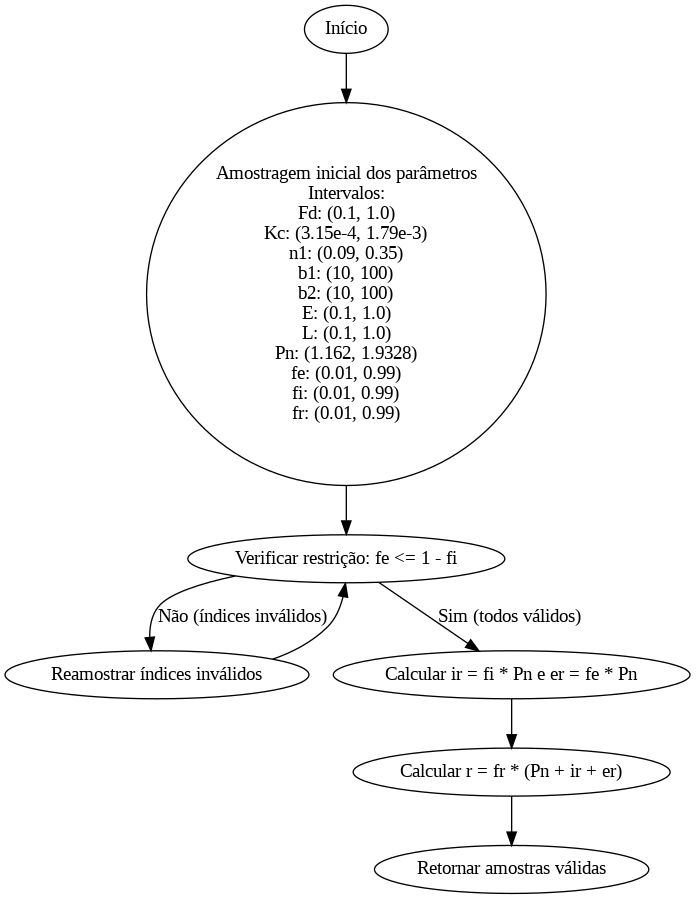

In [ ]:
from graphviz import Digraph

# Criar um gráfico dirigido
flowchart = Digraph(format='png')

# Adicionar os nós principais
flowchart.node('A', 'Início')
flowchart.node('B', 'Amostragem inicial dos parâmetros\nIntervalos:\nFd: (0.1, 1.0)\nKc: (3.15e-4, 1.79e-3)\nn1: (0.09, 0.35)\nb1: (10, 100)\nb2: (10, 100)\nE: (0.1, 1.0)\nL: (0.1, 1.0)\nPn: (1.162, 1.9328)\nfe: (0.01, 0.99)\nfi: (0.01, 0.99)\nfr: (0.01, 0.99)')
flowchart.node('C', 'Verificar restrição: fe <= 1 - fi')
flowchart.node('D', 'Reamostrar índices inválidos')
flowchart.node('E', 'Calcular ir = fi * Pn e er = fe * Pn')
flowchart.node('F', 'Calcular r = fr * (Pn + ir + er)')
flowchart.node('G', 'Retornar amostras válidas')

# Adicionar as conexões entre os nós
flowchart.edge('A', 'B')
flowchart.edge('B', 'C')
flowchart.edge('C', 'D', label='Não (índices inválidos)')
flowchart.edge('D', 'C')
flowchart.edge('C', 'E', label='Sim (todos válidos)')
flowchart.edge('E', 'F')
flowchart.edge('F', 'G')

# Renderizar e salvar o fluxograma
flowchart.render('fluxograma_geracao_amostras', cleanup=True)

# Exibir o fluxograma no Google Colab
from IPython.display import Image
Image('fluxograma_geracao_amostras.png')


# Experimento

Neste experimento, a variável tempo é externa aos parâmetros. Desta forma, para cada instante de tempo, é feita a execução do método. Por exemplo, se são 100 anos e de década em década, realizamos o monte carlo com K iterações.

### Parâmetros do Monte Carlo

In [6]:
# Parâmetros de Monte Carlo
n_simulations = 100000#500000#1000000  # Número de amostras para cada tempo t

# Variável de tempo (de 1 a X, de 10 em 10)
t_values = np.arange(0, 310, 10)
t_values[0] = 1
t_values

array([  1,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300])

### Amostra que será trabalhada (algumas eliminadas por inviabilidade)

In [7]:
# Amostragem dos parâmetros (Monte Carlo)
samples = generate_valid_samples(param_ranges, n_simulations)
pd.DataFrame(samples).describe()

,Fd,Kc,n1,b1,b2,E,L,Pn,fe,fi,fr,ir,er,r
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.548854,0.001052,0.219974,55.045173,55.077729,0.548623,0.549908,1.546789,0.337433,0.336614,0.498777,0.520538,0.521988,1.291878
std,0.259772,0.000425,0.075298,25.959481,25.995440,0.259752,0.259605,0.222062,0.231384,0.230945,0.283359,0.368202,0.369358,0.792081
min,0.100003,0.000315,0.090000,10.000336,10.000191,0.100000,0.100017,1.162003,0.010001,0.010008,0.010014,0.011813,0.011741,0.014767
25%,0.323904,0.000684,0.154602,32.593496,32.525143,0.324415,0.325150,1.354867,0.141964,0.140903,0.252902,0.214254,0.214895,0.628119
50%,0.547894,0.001053,0.219972,54.977567,55.106254,0.547574,0.548899,1.545595,0.297696,0.297210,0.499409,0.452107,0.452583,1.236965
75%,0.773686,0.001420,0.285344,77.552305,77.599934,0.772542,0.774568,1.738427,0.501969,0.499030,0.744479,0.763878,0.769076,1.876317
max,0.999999,0.001790,0.349992,99.999888,99.998864,0.999996,0.999995,1.932798,0.988146,0.989733,0.989988,1.881075,1.869886,3.756169


### Execução

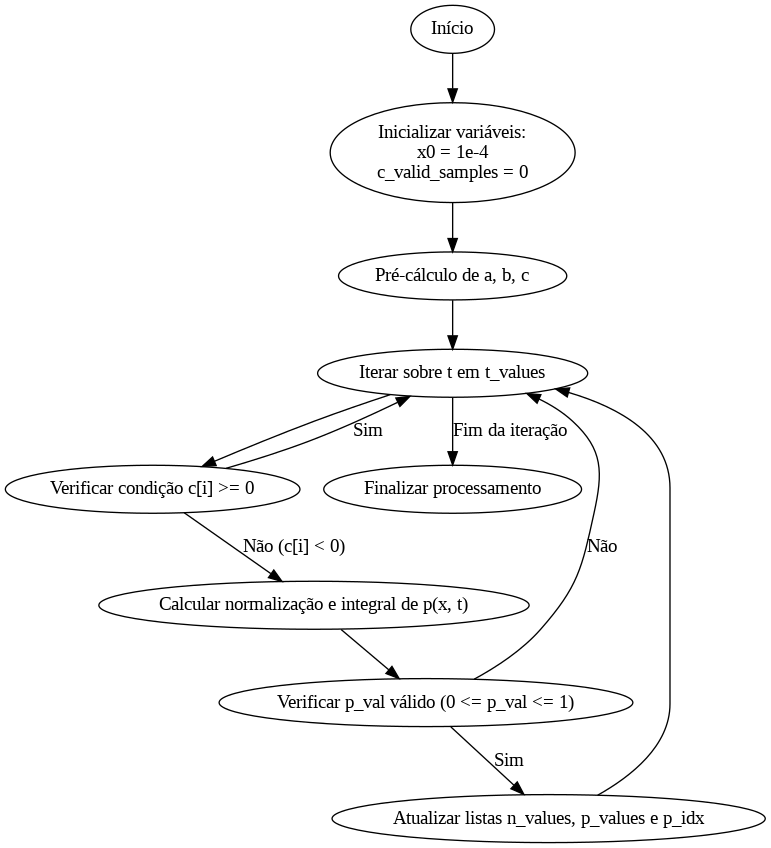

In [ ]:
from graphviz import Digraph

# Criar um gráfico dirigido para o novo código
flowchart = Digraph(format='png')

# Adicionar os nós principais
flowchart.node('A', 'Início')
flowchart.node('B', 'Inicializar variáveis:\nx0 = 1e-4\nc_valid_samples = 0')
flowchart.node('C', 'Pré-cálculo de a, b, c')
flowchart.node('D', 'Iterar sobre t em t_values')
flowchart.node('E', 'Verificar condição c[i] >= 0')
flowchart.node('F', 'Calcular normalização e integral de p(x, t)')
flowchart.node('G', 'Verificar p_val válido (0 <= p_val <= 1)')
flowchart.node('H', 'Atualizar listas n_values, p_values e p_idx')
flowchart.node('I', 'Finalizar processamento')

# Adicionar as conexões entre os nós
flowchart.edge('A', 'B')
flowchart.edge('B', 'C')
flowchart.edge('C', 'D')
flowchart.edge('D', 'E')
flowchart.edge('E', 'F', label='Não (c[i] < 0)')
flowchart.edge('F', 'G')
flowchart.edge('G', 'H', label='Sim')
flowchart.edge('G', 'D', label='Não')
flowchart.edge('H', 'D')
flowchart.edge('E', 'D', label='Sim')
flowchart.edge('D', 'I', label='Fim da iteração')

# Renderizar e salvar o fluxograma
flowchart.render('fluxograma_integral_calculo', cleanup=True)

# Exibir o fluxograma no Google Colab
from IPython.display import Image
Image('fluxograma_integral_calculo.png')


In [8]:
x0 = 1e-4
c_valid_samples = 0
n_values, p_values, p_idx = [], [], []
ptime_values,ptime_idx_values = {},{}

# Pré-cálculo para acelerar
a = np.zeros(n_simulations)
b = np.zeros(n_simulations)
c = np.zeros(n_simulations)

# Calcular a, b, c
for i in range(n_simulations):
    a[i] = calc_a(samples["Kc"][i], samples["b1"][i], samples["b2"][i], samples["L"][i], samples["n1"][i])
    b[i] = calc_b(samples["Kc"][i], samples["E"][i], samples["n1"][i])
    c[i] = calc_c(samples["Kc"][i], samples["Fd"][i], samples["Pn"][i], samples["ir"][i], samples["er"][i], samples["r"][i],samples["n1"][i])

for t in tqdm(t_values, desc="Progresso", leave=True):
    ptime_values[t],ptime_idx_values[t] = [],[]
    for i in prange(n_simulations):
        if c[i] >= 0:
            continue

        fdi = samples["Fd"][i]
        n1  = samples["n1"][i]

        # Calcular normalização
        n = normalizacao(p, t, a[i], b[i], c[i], x0, fdi, n1)

        if n == 0:
            continue

        # Integral de p(x, t)
        p_val = integral_p(p, t, a[i], b[i], c[i], x0, fdi, n1)
        p_val = p_val/n

        if p_val > 1 or p_val < 0:
            continue

        n_values.append(n)
        p_values.append(p_val)
        ptime_values[t].append(p_val)
        ptime_idx_values[t].append(i)

        p_idx.append(i)
        c_valid_samples += 1

p_values = np.array(p_values)

overall = n_simulations * len(t_values)
print("Total iterations =", overall)
print("Valid samples =", c_valid_samples)
print("Invalid samples =", overall - c_valid_samples)

Progresso:   0%|          | 0/31 [00:00<?, ?it/s]

Total iterations = 3100000
Valid samples = 1800507
Invalid samples = 1299493


### Execução em múltiplos processos (só vale a pena numa máquina com múltiplas threads)

## Preparação de dados para análise


In [9]:

# Há amostras repetidas, porém com p_values distintos, pois variamos o tempo.
p_samples = []
df = pd.DataFrame(samples)
for idx in p_idx:
    p_samples.append(df.iloc[idx])

print(len(p_idx),len(p_values),len(p_samples))

parameters = df.columns.tolist()


1800507 1800507 1800507


In [10]:
p_samples = pd.DataFrame(p_samples)
p_samples.describe()

,Fd,Kc,n1,b1,b2,E,L,Pn,fe,fi,fr,ir,er,r
count,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06,1.800507e+06
mean,5.566123e-01,1.044167e-03,2.201154e-01,5.525819e+01,5.521292e+01,5.513298e-01,5.534768e-01,1.543296e+00,2.485818e-01,3.876197e-01,3.663417e-01,5.977393e-01,3.838735e-01,9.159114e-01
std,2.587626e-01,4.254321e-04,7.517381e-02,2.591876e+01,2.594389e+01,2.589606e-01,2.586085e-01,2.220642e-01,1.876926e-01,2.367818e-01,2.348418e-01,3.778080e-01,2.980530e-01,6.199152e-01
min,1.000046e-01,3.150201e-04,9.000017e-02,1.000034e+01,1.000019e+01,1.000003e-01,1.000167e-01,1.162008e+00,1.000110e-02,1.000751e-02,1.001406e-02,1.194847e-02,1.174109e-02,1.476748e-02
25%,3.337777e-01,6.749199e-04,1.550204e-01,3.285796e+01,3.284184e+01,3.286130e-01,3.309837e-01,1.351176e+00,9.656758e-02,1.898155e-01,1.675457e-01,2.864397e-01,1.456385e-01,4.122619e-01
50%,5.590133e-01,1.040072e-03,2.198214e-01,5.528350e+01,5.529671e+01,5.514600e-01,5.532350e-01,1.540648e+00,2.034585e-01,3.646692e-01,3.364599e-01,5.535711e-01,3.106779e-01,8.192697e-01
75%,7.807342e-01,1.410449e-03,2.853888e-01,7.772847e+01,7.770627e+01,7.738702e-01,7.775414e-01,1.735224e+00,3.629859e-01,5.666316e-01,5.398134e-01,8.638130e-01,5.551273e-01,1.312317e+00
max,9.999948e-01,1.789965e-03,3.499822e-01,9.999968e+01,9.999886e+01,9.999960e-01,9.999953e-01,1.932798e+00,9.641332e-01,9.897329e-01,9.848268e-01,1.881075e+00,1.815926e+00,3.596661e+00


# Análise de Resultados

O objetivo é analisar o efeito/correlação de cada variável com relação à probabilidade de transbordo.  

### Distribuição dos resultados das probabilidades da simulação

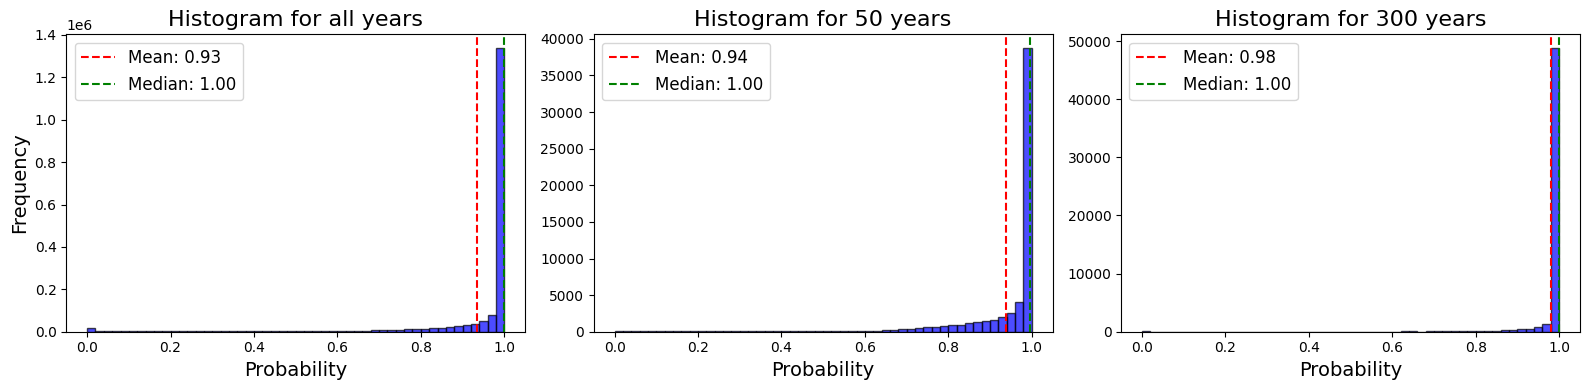

In [11]:
# Parâmetros do histograma
num_bins = 50  # Number of bins in the histogram

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

# General histogram (p_values)
axes[0].hist(p_values, bins=num_bins, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title("Histogram for all years", fontsize=16)
axes[0].set_xlabel("Probability", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)

# Auxiliary lines (mean and median)
mean_value = np.mean(p_values)
median_value = np.median(p_values)
axes[0].axvline(mean_value, color='red', linestyle='--', label=f"Mean: {mean_value:.2f}")
axes[0].axvline(median_value, color='green', linestyle='--', label=f"Median: {median_value:.2f}")
axes[0].legend(fontsize=12)

# Histogram for ptime_values[50]
axes[1].hist(ptime_values[50], bins=num_bins, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_title("Histogram for 50 years", fontsize=16)
axes[1].set_xlabel("Probability", fontsize=14)

# Auxiliary lines (mean and median)
mean_value = np.mean(ptime_values[50])
median_value = np.median(ptime_values[50])
axes[1].axvline(mean_value, color='red', linestyle='--', label=f"Mean: {mean_value:.2f}")
axes[1].axvline(median_value, color='green', linestyle='--', label=f"Median: {median_value:.2f}")
axes[1].legend(fontsize=12)

# Histogram for ptime_values[300]
axes[2].hist(ptime_values[300], bins=num_bins, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title("Histogram for 300 years", fontsize=16)
axes[2].set_xlabel("Probability", fontsize=14)

# Auxiliary lines (mean and median)
mean_value = np.mean(ptime_values[300])
median_value = np.median(ptime_values[300])
axes[2].axvline(mean_value, color='red', linestyle='--', label=f"Mean: {mean_value:.2f}")
axes[2].axvline(median_value, color='green', linestyle='--', label=f"Median: {median_value:.2f}")
axes[2].legend(fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


### Análise de dispersão variável vs probabilidade

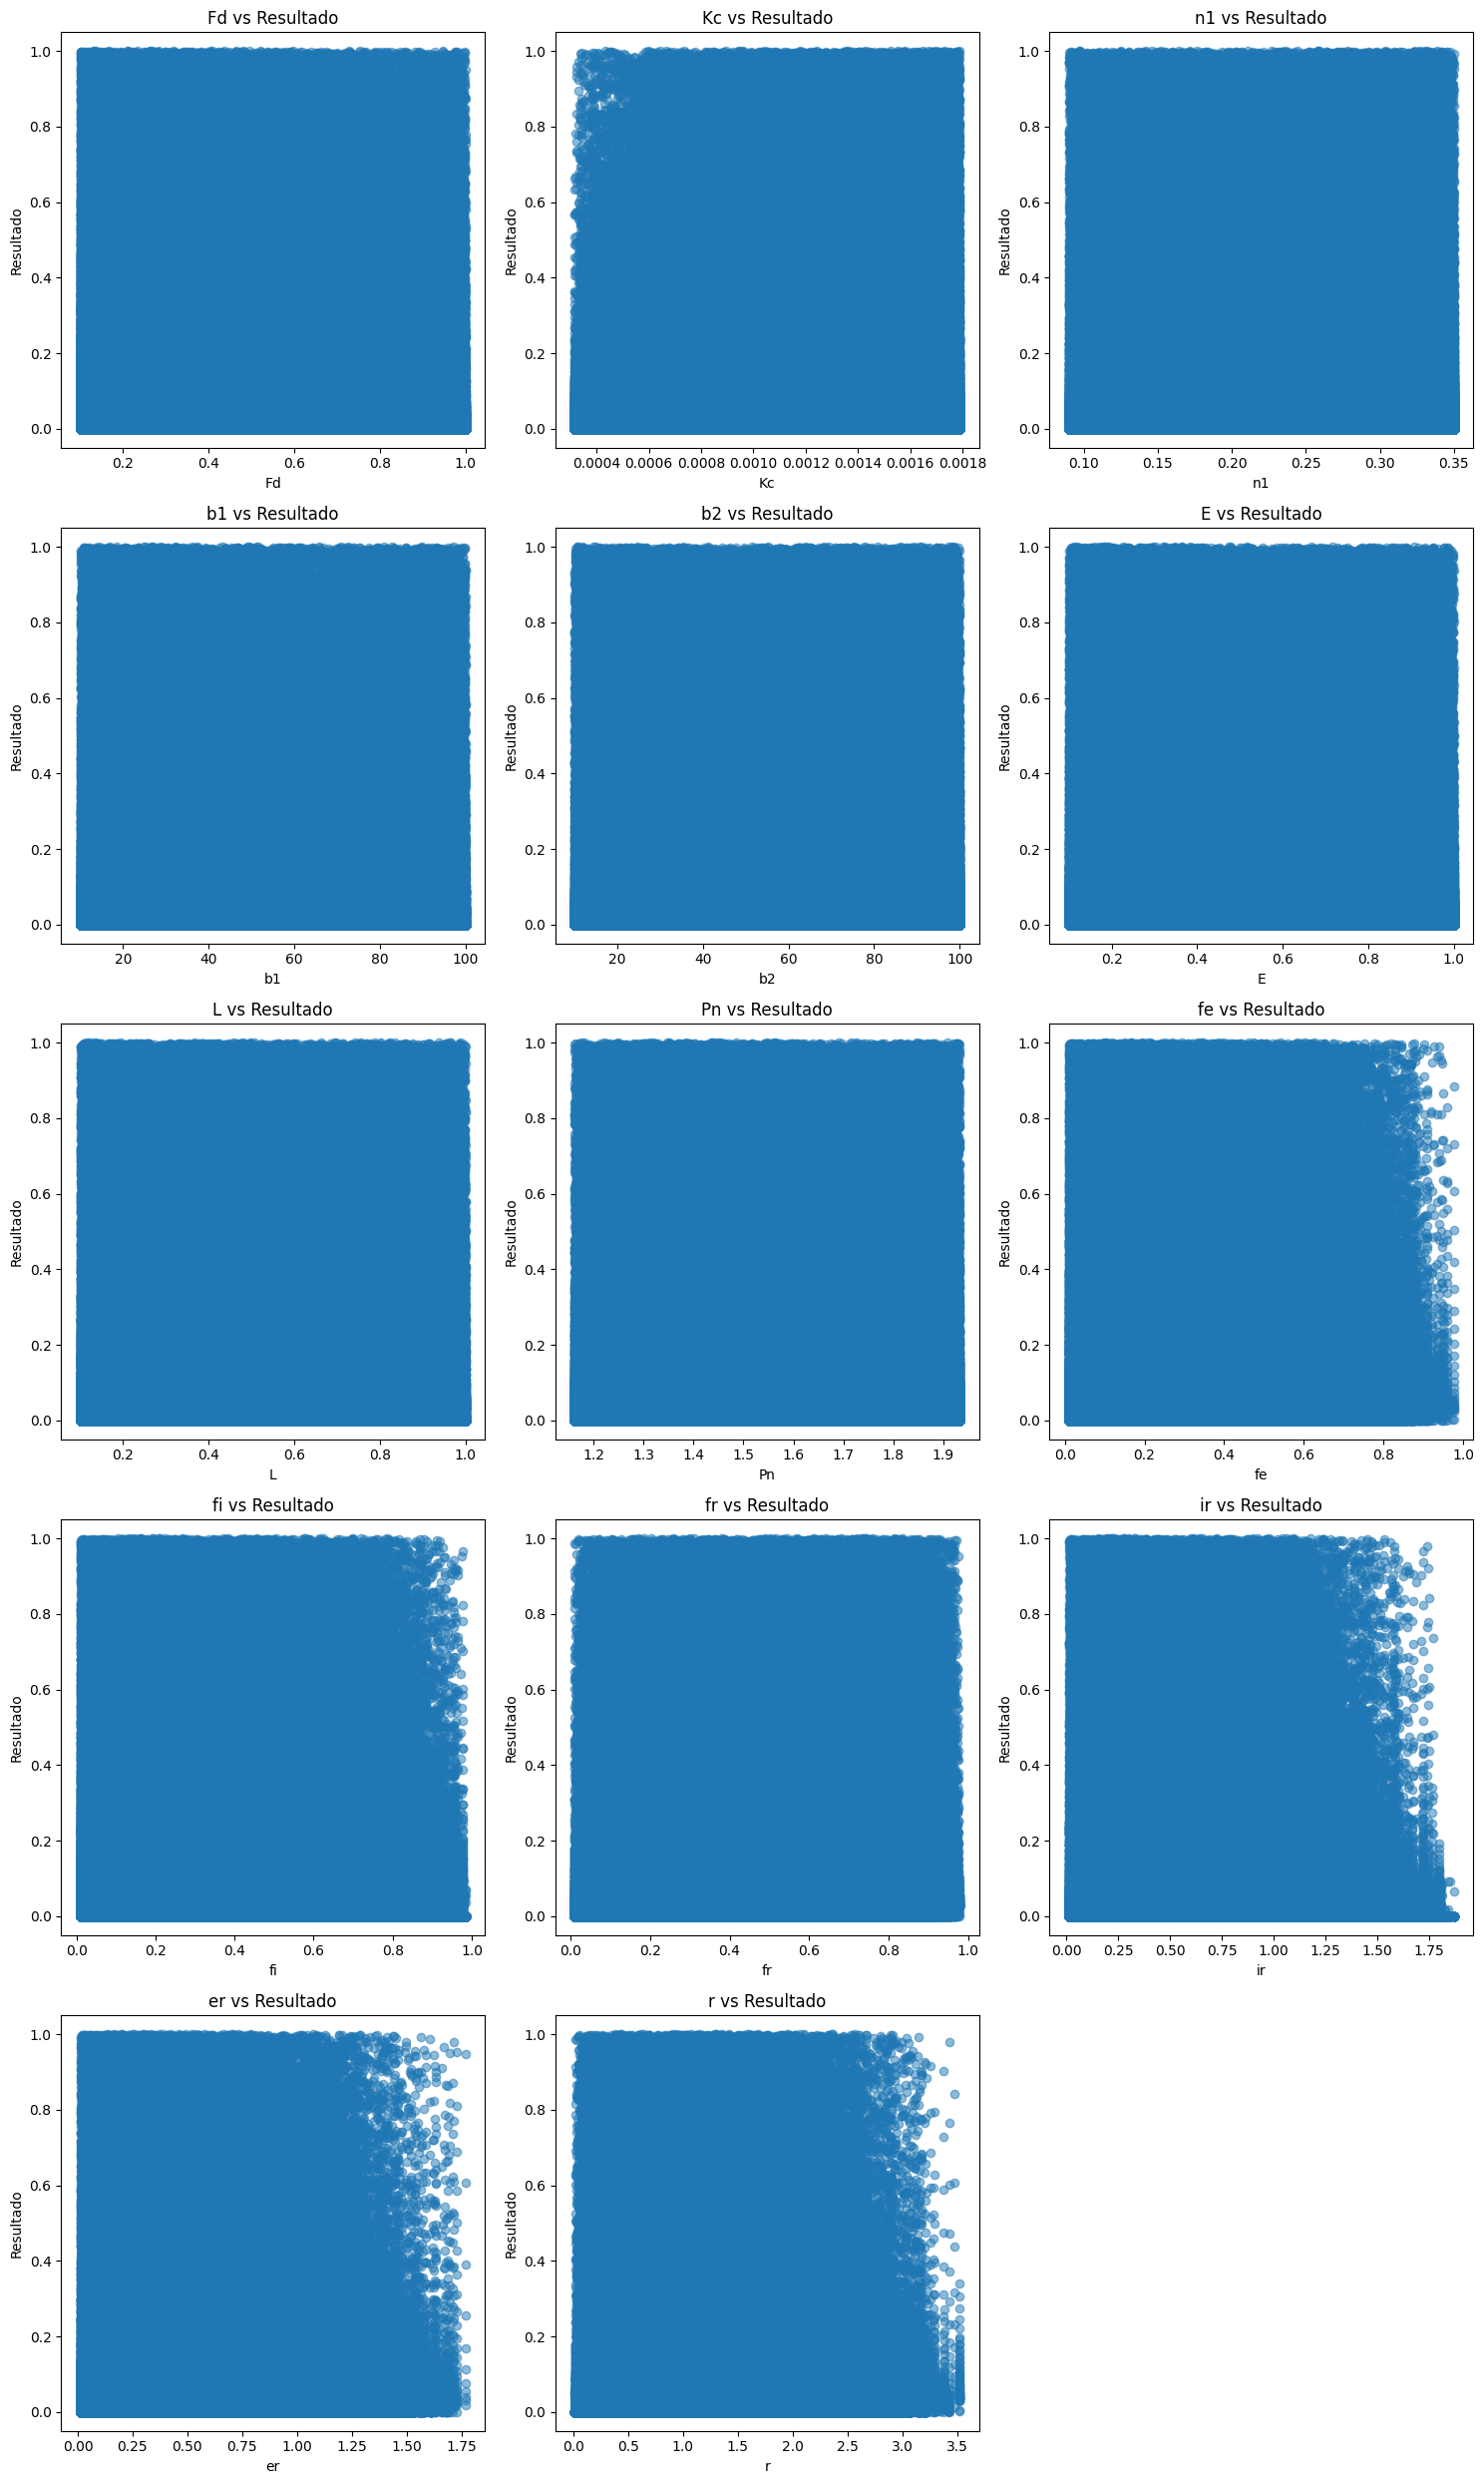

In [30]:
import matplotlib.pyplot as plt
import math

# Configurar o grid
n_params = len(parameters)
n_cols = 3  # Número de colunas
n_rows = math.ceil(n_params / n_cols)  # Número de linhas (arredondar para cima)

# Criar subfiguras
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Achatar para iterar facilmente

# Plotar cada parâmetro
for idx, param in enumerate(parameters):
    ax = axes[idx]
    ax.scatter(p_samples[param], p_values, alpha=0.5)
    ax.set_xlabel(param)
    ax.set_ylabel("Resultado")
    ax.set_title(f"{param} vs Resultado")

# Remover subplots vazios, se houver
for idx in range(n_params, len(axes)):
    fig.delaxes(axes[idx])

# Ajustar layout
plt.tight_layout()
plt.show()


### Análise por Correlação

In [12]:
# Análise de sensibilidade
sensitivities = {}
for param in parameters:
    correlation = np.corrcoef(p_samples[param], p_values)[0, 1]
    sensitivities[param] = correlation

# Ordenar sensibilidades por magnitude
sorted_sensitivities = sorted(sensitivities.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_sensitivities


[('fr', np.float64(-0.18392505809274523)),
 ('r', np.float64(-0.16110097224835815)),
 ('Fd', np.float64(0.1502310662664114)),
 ('fe', np.float64(-0.08547601520269868)),
 ('er', np.float64(-0.0761869270206643)),
 ('n1', np.float64(-0.07353395660916302)),
 ('ir', np.float64(0.06905174717875333)),
 ('fi', np.float64(0.06506440078107922)),
 ('E', np.float64(0.048585318640664246)),
 ('Pn', np.float64(0.03120409063149372)),
 ('L', np.float64(-0.024293881732146954)),
 ('Kc', np.float64(-0.012673004471017083)),
 ('b1', np.float64(-0.009592443295778961)),
 ('b2', np.float64(-0.009382852589665917))]

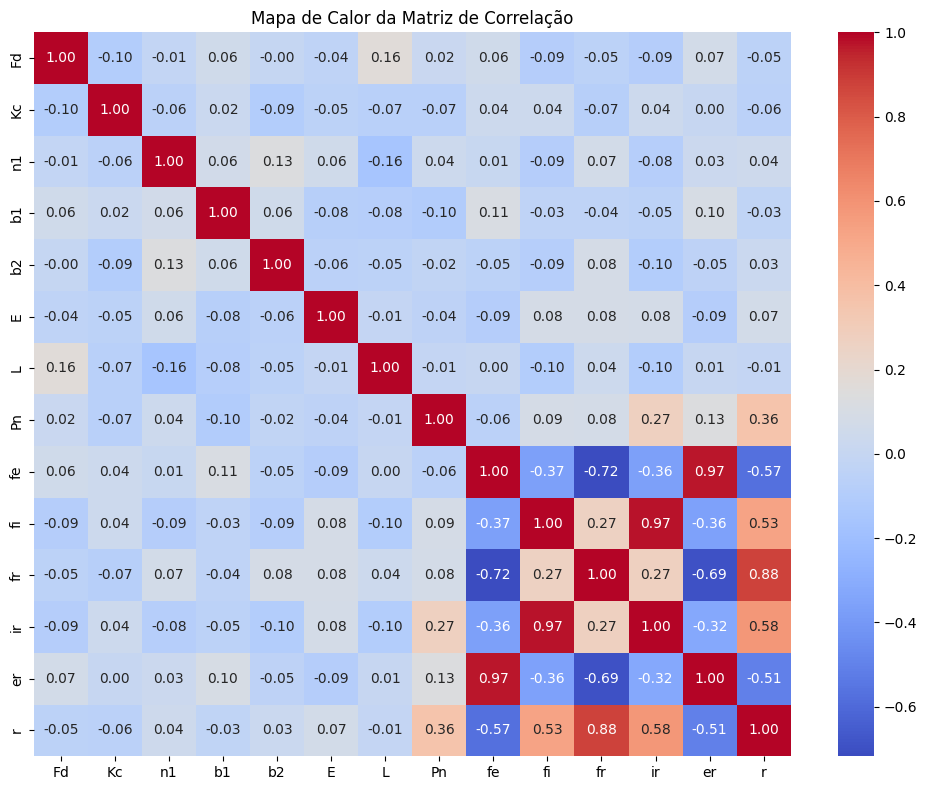

In [18]:

# Inicializar a matriz de correlação
correlation_matrix = np.zeros((len(parameters), len(parameters)))

# Preencher a matriz de correlação
for i, param_i in enumerate(parameters):
    for j, param_j in enumerate(parameters):
        if i <= j:  # Calcular apenas os elementos acima da diagonal principal
            correlation = np.corrcoef(p_samples[param_i], p_samples[param_j])[0, 1]
            correlation_matrix[i, j] = correlation
            correlation_matrix[j, i] = correlation

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, xticklabels=parameters, yticklabels=parameters, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor da Matriz de Correlação")
plt.tight_layout()
plt.show()

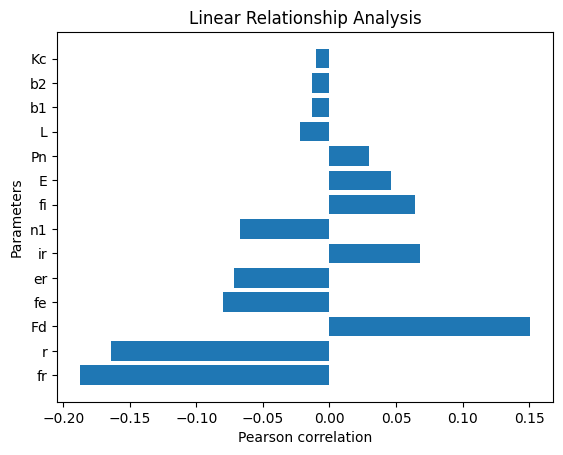

In [14]:
import matplotlib.pyplot as plt

# Gráfico de barras para sensibilidades
params, values = zip(*sorted_sensitivities)
plt.barh(params, values)
plt.xlabel("Pearson correlation")
plt.ylabel("Parameters")
plt.title("Linear Relationship Analysis")
plt.show()


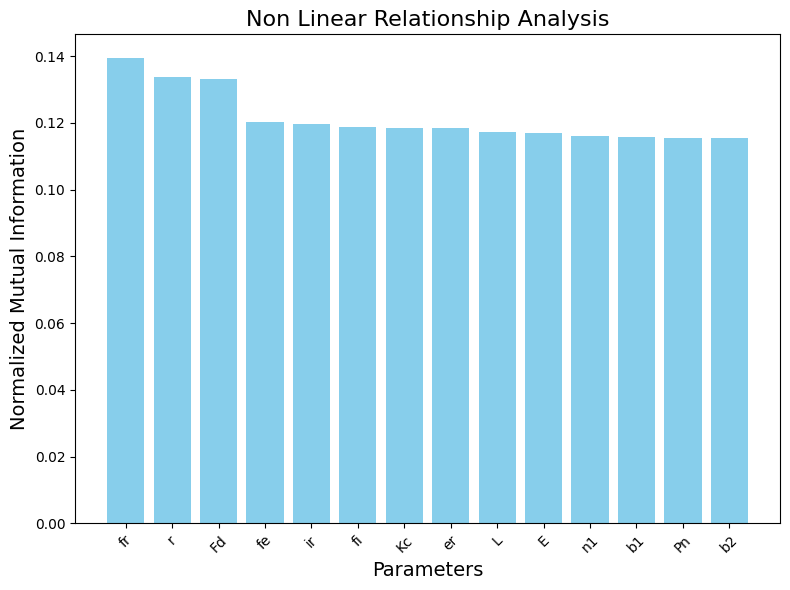

In [15]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt

# Calcular a entropia do alvo (p_values)
def calculate_entropy(values):
    value_counts = np.histogram(values, bins=50)[0]  # Frequências dos valores
    probabilities = value_counts / np.sum(value_counts)  # Converter para probabilidades
    return entropy(probabilities, base=2)  # Entropia com base 2

# Entropia do alvo (p_values)
target_entropy = calculate_entropy(p_values)

# Análise de informação mútua com normalização por entropia
sensitivities = {}
for param in parameters:
    mi = mutual_info_regression(p_samples[param].values.reshape(-1, 1), p_values)[0]
    sensitivities[param] = mi / target_entropy  # Normalizar pela entropia do alvo

# Ordenar sensibilidades normalizadas por magnitude
sorted_sensitivities = sorted(sensitivities.items(), key=lambda x: abs(x[1]), reverse=True)

# Preparar dados para o gráfico
params = [x[0] for x in sorted_sensitivities]
nmi_values = [x[1] for x in sorted_sensitivities]

# Plotar gráfico
plt.figure(figsize=(8, 6))
plt.bar(params, nmi_values, color='skyblue')
plt.xlabel('Parameters', fontsize=14)
plt.ylabel('Normalized Mutual Information', fontsize=14)
plt.title('Non Linear Relationship Analysis', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Análise não linear de importância de variáveis - Machine Learning

In [14]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm

# Escolha do modelo: 'lightgbm' ou 'xgboost'
model_type = "lightgbm"  # Altere para 'xgboost' conforme necessário

# Dados
X = np.column_stack([p_samples[param] for param in parameters])
y = p_values

# Configuração da validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Inicializar o modelo com base na escolha
if model_type == "lightgbm":
    model = lgb.LGBMRegressor(n_estimators=100, max_depth=-1, learning_rate=0.1, random_state=42, n_jobs=-1)
elif model_type == "xgboost":
    model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, tree_method='hist', n_jobs=-1)

# Listas para armazenar as métricas e valores de SHAP
mae_scores = []
shap_values_all = []
test_indices_all = []

# Validação cruzada para calcular valores SHAP em cada fold
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Treinar modelo
    model.fit(X_train, y_train)

    # Previsões do modelo
    y_pred = model.predict(X_test)

    # Calcular as métricas de avaliação
    mae = mean_absolute_error(y_test, y_pred)

    # Armazenar as métricas
    mae_scores.append(mae)

    # Criar o explicador SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Armazenar valores SHAP e índices de teste
    shap_values_all.append(shap_values)
    test_indices_all.append(test_index)

# Combinar valores SHAP e reordenar para coincidir com a ordem original de X
shap_values_combined = np.zeros_like(np.vstack(shap_values_all))  # Inicializa com zeros
for shap_values, test_indices in zip(shap_values_all, test_indices_all):
    shap_values_combined[test_indices] = shap_values

# Exibir as métricas de avaliação
print(f"MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1440405, number of used features: 14
[LightGBM] [Info] Start training from score 0.934039


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1440405, number of used features: 14
[LightGBM] [Info] Start training from score 0.934173


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1440406, number of used features: 14
[LightGBM] [Info] Start training from score 0.934081


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1440406, number of used features: 14
[LightGBM] [Info] Start training from score 0.934051


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 1440406, number of used features: 14
[LightGBM] [Info] Start training from score 0.934143


C:\Users\alvim\OneDrive\Documentos\workspace\nuclear\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
5it [01:31, 18.37s/it]


MAE: 0.0694 ± 0.0001


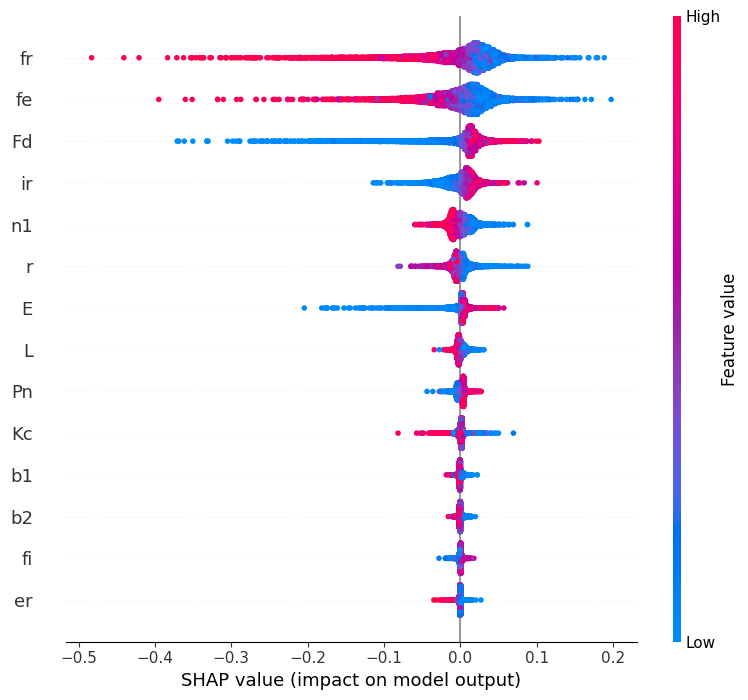

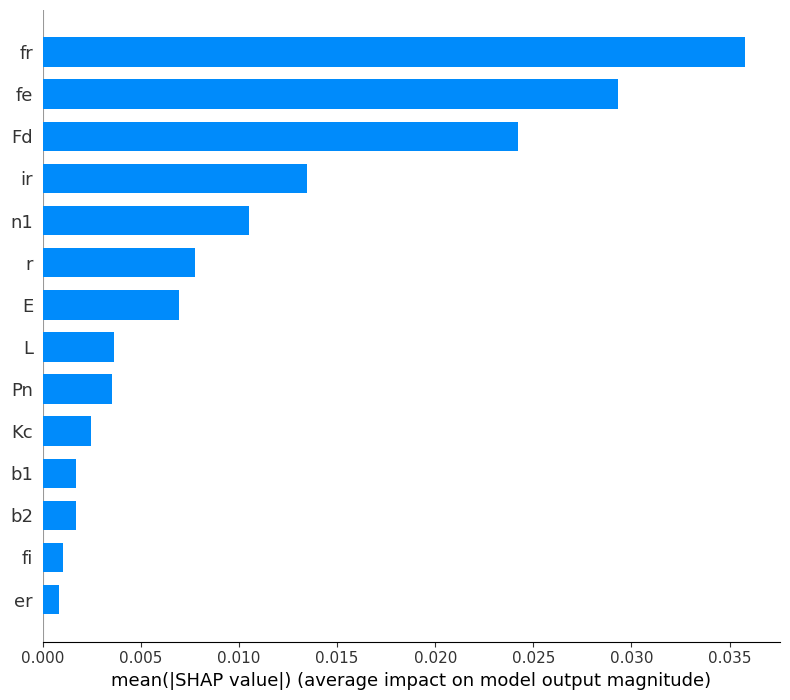

<Figure size 1000x600 with 0 Axes>

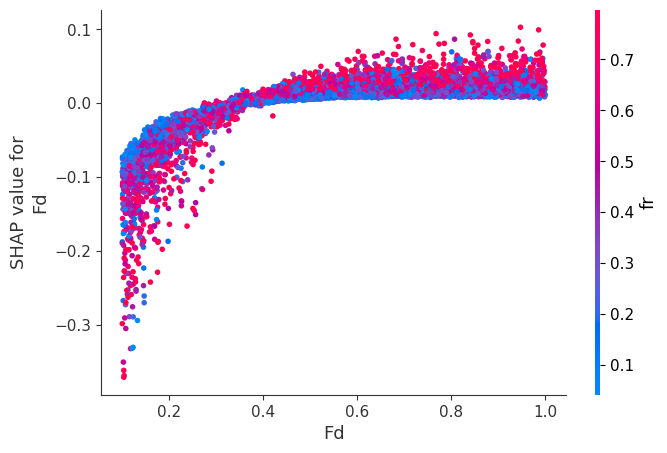

In [17]:
# Amostrar os dados para evitar lentidão nos gráficos
sample_size = 10000  # Ajuste conforme necessário
if X.shape[0] > sample_size:
    idx = np.random.choice(X.shape[0], sample_size, replace=False)  # Amostra os mesmos índices para X e SHAP values
    X_sample = X[idx]
    shap_values_sample = shap_values_combined[idx]
else:
    X_sample = X
    shap_values_sample = shap_values_combined

# Nomes das variáveis
feature_names = list(parameters)

# Gráficos SHAP

# Gráfico 1: Beeswarm Plot (Impacto global das variáveis)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_sample, X_sample, feature_names=feature_names)

# Gráfico 2: Bar Plot (Importância média das variáveis)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_sample, X_sample, feature_names=feature_names, plot_type="bar")

# Gráfico 3: Dependência parcial de uma variável
plt.figure(figsize=(10, 6))
shap.dependence_plot(0, shap_values_sample, X_sample, feature_names=feature_names)  # Alterar o índice para outras variáveis


plt.show()


In [ ]:
import shap

Analisar ainda

# Teste Interativo

In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display


# Função interativa
def interactive_calculation(Fd, Kc, n1, b1, b2, E, L_val, Pn, fe, fi, fr):
    x0 = 1e-4
    t = 1  # Exemplo fixo para t

    # Calcular os valores dependentes
    ir = fi * Pn
    er = fe * Pn
    r = fr * (Pn + ir + er)

    # Calcula os parâmetros
    a = calc_a(Kc, b1, b2, L_val, n1)
    b = calc_b(Kc, E, n1)
    c = calc_c(Kc, Fd, Pn, ir, er, r, n1)
    print("a = ",a)
    # Rejeita se c >= 0
    if c >= 0:
        display("C inválido (c >= 0). Ajuste os parâmetros.")
        return

    # Calcula o fator de normalização
    s, j, dx, x, k = 0.0, 0, 0.25, 1e-4, 60
    while j < k:
        j += 1
        x += dx
        s += p(x, t, a, b, c, x0, Fd, n1)
    n = s

    # Rejeita qualquer fator de normalização igual a zero
    if n == 0:
        display("Fator de normalização inválido (n = 0). Ajuste os parâmetros.")
        return

    # Calcula integral de p(x, t)
    s = 0.0
    x_vals = list(np.linspace(4.38, 15, 50))
    for x in x_vals:
        s += p(x, t, a, b, c, x0, Fd, n1)
    p_val = s / n

    # Verifica se a integral está fora do intervalo [0, 1]
    if p_val > 1 or p_val < 0:
        display("p_val fora do intervalo [0, 1]. Ajuste os parâmetros.")
    else:
        display(f"p_val = {p_val:.6f}")

    # Exibe os valores calculados
    display(f"ir = {ir:.6f}, er = {er:.6f}, r = {r:.6f}")

    # Atualiza o gráfico de barras
    values = [p_val, a, b, c]
    labels = ["p_val", "calc_a", "calc_b", "calc_c"]
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values)
    plt.ylim(-5, max(values) * 1.2 + 5)
    plt.ylabel("Value")
    plt.title("Valores calculados")
    plt.show()

# Observador para garantir fe <= 1 - fi
def update_fe_range(change):
    fi_value = change['new']
    fe_slider.max = 1 - fi_value
    if fe_slider.value > fe_slider.max:
        fe_slider.value = fe_slider.max

#fi_slider.observe(update_fe_range, names='value')
# Widgets interativos
Fd_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.01, description='Fd')
Kc_slider = widgets.FloatSlider(value=1e-3, min=3.15e-4, max=1.79e-3, step=1e-5, description='Kc')
n1_slider = widgets.FloatSlider(value=0.2, min=0.09, max=0.35, step=0.01, description='n1')
b1_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='b1')
b2_slider = widgets.FloatSlider(value=50, min=10, max=100, step=1, description='b2')
E_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.01, description='E')
L_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.01, description='L_val')
Pn_slider = widgets.FloatSlider(value=1.5, min=1.162, max=1.9328, step=0.01, description='Pn')
fe_slider = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='fe')
fi_slider = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='fi')
fr_slider = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='fr')
er_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='er')
ir_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='ir')
r_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.01, description='r')

# Display dos widgets
ui = widgets.VBox([
    Fd_slider, Kc_slider, n1_slider, b1_slider, b2_slider, E_slider,
    L_slider, Pn_slider, fe_slider, fi_slider, fr_slider
])

out = widgets.interactive_output(
    interactive_calculation,
    {
        'Fd': Fd_slider, 'Kc': Kc_slider, 'n1': n1_slider,
        'b1': b1_slider, 'b2': b2_slider, 'E': E_slider,
        'L_val': L_slider, 'Pn': Pn_slider, 'fe': fe_slider,
        'fi': fi_slider, 'fr': fr_slider
    }
)

display(ui, out)


Output()